# Deploying a machine learning application
Building a machine learning model is only half the story. Deploying this application so that the business uses it is the other half. Generally, deployment is not done by machine learning engineers, or data scientists. Therefore I see a huge lacking in these skills in my peers.  
Although deployment is done by python developers, it is important for data scientists to know the basics of deploying a machine learning solution.  
In the below example, I am using the data taken from [aqicn.org](https://aqicn.org/) on the PM25 pollutant near my house in Hyderabad, India. I am using this data to build a model that will predict the Air Quality near my home. This is the machine learing model that I want to deploy a HTTP request.  
I have used [pythonanywhere](https://www.pythonanywhere.com/) to deploy a flask application which "GET"s the PM25 prediction for the date provided.   
  
First let me build a machine learning model. The training data can be found at [aqicn's api](https://aqicn.org/data-platform/register/)  

In [1]:
import pandas as pd
data = pd.read_csv('hyderabad-us consulate-air-quality.csv', parse_dates=['date'])

In [2]:
data.columns = ['date', 'pm25']
data

,date,pm25
0,2021-10-01,87
1,2021-10-02,47
2,2021-10-03,50
3,2021-09-01,66
4,2021-09-02,74
...,...,...
2302,2014-12-24,165
2303,2014-12-25,165
2304,2014-12-26,163
2305,2014-12-27,165


<AxesSubplot:xlabel='date', ylabel='pm25'>

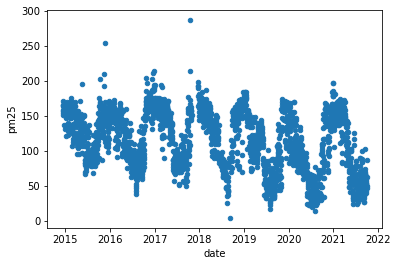

In [3]:
data.plot.scatter(x = 'date', y = 'pm25')

Figure(432x288)


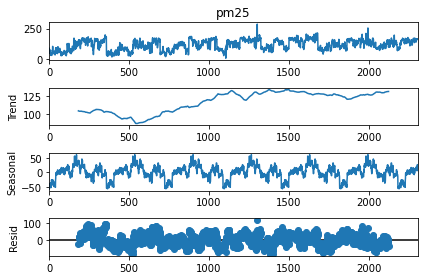

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data.pm25, model='additive', period = 365)
print(result.plot())

We can see the seasonality in the data where the pollution increases during winter and is lower during the summer months. But since this is not a machine learning blog, we are going to ignore building a model. Instead our prediction will simply be an average of the past data. My intention in this post is not to build a machine learning model, but show how it can be deployed. The more complex model along with the code can be found in my [github repo](https://github.com/HarshaAsh/mc_learning_as_HTTP_request).

In [5]:
data.pm25.mean()

115.66666666666667

## Deployment
The best way to deploy the machine learning model (according to me) is to encapsulate the trainig and prediction logic behind the data science model alon with the final model. This can be done by using a class as shown below, and serialise/deserialise the class. This way we can move around the machine learning model along with the training and prediction code, and we need not re-write the prediction code in the server side everytime we do a change in the machine learnig model or code. We can only change the final model file, and the application should work seamlessly.  
Consider the below code which encapsulates the machine learning model:

In [6]:
import dill # dill is an alternative to pickle which is better for serialising objects along with their class definitions
class predict_pm25:
    def __init__(self):
        self.model = None
        self.version = 1
    def predict(self, time):
        return [115.6] # return a list
    def save_model(self):
        with open('predict_hyderabad_pm25.pkl', "wb") as pkl_file:
            dill.dump(self, pkl_file)

Running the code to save the model as a serialised file.

In [7]:
predict_pm = predict_pm25()
predict_pm.save_model()

## Flask
Flask server can be used to deploy this model. First, we set up flask server over local host. First, write the following code in a file named **flask_app.py** (any name except flask.py)

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
from mc_predict import predict as machine_learning_predict # has code for the predict function

app = Flask(__name__) # initialising the flask app


@app.route("/") # specifying the app route over the web
def base_website(): # what should happen at this route
    return "Welcome to machine learning model APIs!"

@app.route('/predict', methods=['GET']) # Get request defined
def predict_request(): # what should happen at this get request
    json_ = request.json
    query_df = pd.DataFrame(json_)
    prediction = machine_learning_predict(query_df) # we call the predict function for the machine learning model
    return jsonify({'prediction': list(prediction)})


if __name__ == '__main__':
    app.run(debug=True)

The predict function is defined in a different file called **mc_predict.py**. In this function, we load (unserialise) the saved model and call the predict function in the model.  

In [ ]:
import dill
def predict(df):
    with open('predict_hyderabad_pm25.pkl', "rb") as pkl_file:
        model = dill.load(pkl_file) # unserialise the model
    return model.predict(df)

Thats it, we have our local deployment ready. We will have to go to the folder where these files are present, and type the command *python flask_app.py*. We will get the app running on *http://127.0.0.1:5000/*. For GET request, we can type is *http://127.0.0.1:5000/predict?time="12/10/2021"* to get the prediction for the time 12/10/2021. 

## Pythonanywhere
The next step is to deploy it on pythonanywhere. The first step is to sign up for a new account. We can then "Add a new web app" with Flask 3.7. This will create a default flask based webapp with your username.pythonanywhere.com. We can install any packages necessary using the "Console" (example *pip install dill*). In the files tab, under *mysite* are the flask files. These should be replaced with the files that we have above. The model file should also be uploaded. (We should take care of the relative location of the model file while loading it). Under *Web* tab, we can *Reload the model* which will rebuild the application. We now have our machine learning model deployed.   

For the model I deployed, hit the GET request [https://harshaash.pythonanywhere.com/predict?time=12/10/2021](https://harshaash.pythonanywhere.com/predict?time=12/10/2021). The complete code can be found at [my Github](https://github.com/HarshaAsh/mc_learning_as_HTTP_request).

## References:  
1. Deployment: https://medium.com/analytics-vidhya/how-to-deploy-simple-machine-learning-models-for-free-56cdccc62b8d  
2. https://www.datacamp.com/community/tutorials/machine-learning-models-api-python  
3. Data: https://aqicn.org/json-api/doc/  
4. https://help.pythonanywhere.com/pages/Flask/  